In [14]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

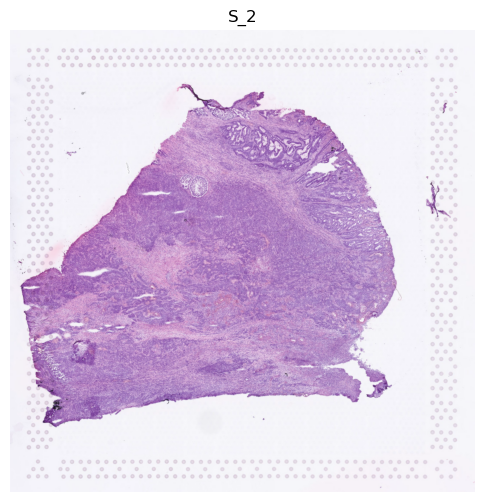

In [25]:
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    
    sample = 'S_2'
    image = np.array(train_images[sample])
    
    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.axis('off')
    plt.title(sample)
    plt.show()

## Training data augmentation

In [4]:

# Load and display (x,y) spot locations and cell type annotation table for Train slides
with h5py.File("./dataset/gu_smooth_processed_train_spots.h5", "r") as f:
    train_spots = f["spots/log2_Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
        print(slide_name)

# Example: Display the spots table for slide 'S_1'
train_spot_tables['S_1']

S_1
S_2
S_3
S_4
S_5
S_6


,x,y,zscore_log2_filtered_C1,zscore_log2_filtered_C2,zscore_log2_filtered_C3,zscore_log2_filtered_C4,zscore_log2_filtered_C5,zscore_log2_filtered_C6,zscore_log2_filtered_C7,zscore_log2_filtered_C8,...,zscore_log2_filtered_C26,zscore_log2_filtered_C27,zscore_log2_filtered_C28,zscore_log2_filtered_C29,zscore_log2_filtered_C30,zscore_log2_filtered_C31,zscore_log2_filtered_C32,zscore_log2_filtered_C33,zscore_log2_filtered_C34,zscore_log2_filtered_C35
0,1554,1297,-0.514671,-0.527123,-0.563804,-0.590141,-0.072443,1.530280,-0.559584,-0.098297,...,-0.021211,1.650772,0.487133,-0.138852,-0.419925,-0.578165,-0.535000,0.333113,-0.252233,-0.428119
1,462,1502,-0.122017,0.812272,-0.068992,-0.526672,1.175373,-0.629460,0.193411,-0.099649,...,0.181140,-0.610282,-0.449470,0.380137,-0.345033,0.884565,0.419742,0.102343,0.027834,0.091678
2,1488,1548,-0.388102,-0.603067,-0.485638,-0.554181,0.647981,-0.088844,-0.514921,-0.632897,...,-0.517626,0.396880,-0.527410,-0.294467,-0.520288,-0.593040,-0.679084,-0.405276,-0.629911,-0.672516
3,1725,1182,-0.654297,0.225429,-0.608075,-0.567198,2.227529,0.235877,0.903801,-0.122890,...,-0.575361,0.141366,-0.506893,0.906409,-0.605025,0.041836,-0.050023,-0.061439,-0.610804,0.039154
4,581,1113,-0.656137,-0.705660,-0.664065,-0.593797,1.171925,-0.644387,-0.405979,-0.640655,...,-0.688633,-0.595324,-0.665471,-0.359357,-0.586169,-0.686027,-0.772372,-0.672342,-0.714066,-0.763687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2144,1055,701,-0.581453,0.310430,-0.509279,-0.630412,-0.840217,1.492043,0.084655,1.294919,...,0.314941,1.579347,1.962398,1.610666,-0.297635,0.005529,0.852539,0.498666,0.834113,1.315026
2145,1225,862,-0.470476,-0.147688,-0.318429,-0.590391,-0.811578,1.817129,-0.019557,0.463349,...,0.684314,1.812015,1.962398,1.584697,-0.616510,-0.399746,0.431132,0.868831,-0.056207,1.327100
2146,765,1479,0.148958,0.057805,0.011017,-0.417220,0.476252,-0.196486,-0.185083,-0.099630,...,0.292047,0.001097,-0.397531,-0.059607,-0.275177,0.135442,0.014355,-0.179212,-0.238346,-0.218637
2147,607,1525,-0.562435,-0.286703,-0.594930,-0.582294,1.009000,-0.602286,-0.441027,-0.521738,...,-0.643426,-0.522671,-0.523506,0.320161,-0.584297,-0.459856,-0.488769,-0.049374,-0.619314,-0.602343


## Tiles

In [15]:
def extract_tile_fixed(image, x, y, tile_size=336, pad_mode='edge'):
    """
    擷取中心為 (x, y) 的 tile，若超出邊界則 padding，並回傳 padding 過的位置（若有）。
    
    Args:
        image: 原始影像 (H, W, C)
        x, y: 中心座標
        tile_size: 擷取的 tile 大小
        pad_mode: np.pad 使用的模式（預設為 'edge'）

    Returns:
        tile: 擷取出來的 tile (tile_size, tile_size, C)
        padded_coords: 若有 padding 則為 [x, y]，否則為 None
    """
    H, W, C = image.shape
    half = tile_size // 2

    x1, x2 = x - half, x + half
    y1, y2 = y - half, y + half

    pad_left = max(0, -x1)
    pad_right = max(0, x2 - W)
    pad_top = max(0, -y1)
    pad_bottom = max(0, y2 - H)

    padded = any([pad_left, pad_right, pad_top, pad_bottom])
    if padded:
        image = np.pad(
            image,
            ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
            mode=pad_mode
        )
        # 調整座標
        x1 += pad_left
        x2 += pad_left
        y1 += pad_top
        y2 += pad_top

    tile = image[y1:y2, x1:x2, :]
    return (tile, [x, y]) if padded else (tile, None)



def get_spots_in_tile(df, center_x, center_y, tile_size):
    half = tile_size // 2
    x_min, x_max = center_x - half, center_x + half
    y_min, y_max = center_y - half, center_y + half

    df_in_tile = df[
        (df['x'] >= x_min) & (df['x'] <= x_max) &
        (df['y'] >= y_min) & (df['y'] <= y_max)
    ].copy()

    df_in_tile = df_in_tile[
        ~((df_in_tile['x'] == center_x) & (df_in_tile['y'] == center_y))
    ]

    return df_in_tile


import matplotlib.pyplot as plt
import matplotlib.patches as patches

import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_tile_with_spots(
    slide_image, spot_df, center_x, center_y,
    tile_size=78, stride=None, grid_size=None,
    spot_radius_px=15
):
    """
    可視化一個 tile，包含中心 spot、鄰近 spot，以及可選的 N×N 子區格線。

    Parameters:
    - slide_image: 該張切片的影像 (numpy array, H x W x 3)
    - spot_df: 包含所有落在 tile 內的 spots（已排除中心點）
    - center_x, center_y: 中心 spot 的 slide 座標
    - tile_size: 單一 tile 的大小（像素）
    - stride: tile 間距（默認等於 tile_size，表示無重疊）
    - grid_size: 幾乘幾的 tile（如果 None，就只畫單 tile）
    - spot_radius_px: 中心 spot 畫圓半徑
    """

    if stride is None:
        stride = tile_size

    if grid_size:
        full_tile_size = tile_size + stride * (grid_size - 1)
    else:
        full_tile_size = tile_size

    center_color = 'red'
    neighbor_color = 'orange'
    show_legend = True
    title = f"{len(spot_df)} neighbors in tile"

    # 擷取 tile
    def extract_tile(slide_img, x, y, total_size):
        x, y = int(x), int(y)
        half = total_size // 2
        x1, x2 = x - half, x + half
        y1, y2 = y - half, y + half
        tile = slide_img[y1:y2, x1:x2]
        return tile

    tile = extract_tile(slide_image, center_x, center_y, full_tile_size)

    # 畫圖
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(tile)

    # 畫格線
    # 畫出每個 tile 的實際切割框
    if grid_size:
        for row in range(grid_size):
            for col in range(grid_size):
                x0 = col * stride
                y0 = row * stride
                rect = patches.Rectangle(
                    (x0, y0),
                    tile_size, tile_size,
                    linewidth=1,
                    edgecolor='blue',
                    facecolor='none',
                    linestyle='--'
                )
                ax.add_patch(rect)


    # 中心 spot（固定畫在 tile 中央）
    center_px = full_tile_size // 2
    ax.scatter(center_px, center_px, c=center_color, s=40, label='Center Spot')

    # 中心 spot 圓圈
    circle = patches.Circle(
        (center_px, center_px),
        spot_radius_px,
        linewidth=1.5,
        edgecolor='yellow',
        facecolor='none'
    )
    ax.add_patch(circle)

    # 鄰居 spots（轉成 tile 內相對座標）
    for _, neighbor in spot_df.iterrows():
        dx = int(neighbor['x']) - center_x
        dy = int(neighbor['y']) - center_y
        tile_x = center_px + dx
        tile_y = center_px + dy
        ax.scatter(tile_x, tile_y, c=neighbor_color, s=20)

    ax.axis('off')
    if show_legend:
        ax.legend(loc='upper right')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


## calculate tile_size

In [5]:
from scipy.spatial.distance import pdist, squareform
import numpy as np

train_spacing_per_slide = {}

for slide_id, df in train_spot_tables.items():
    coords = df[['x', 'y']].values
    if len(coords) < 2:
        print(f"⚠️ Slide {slide_id} has less than 2 spots, skipping.")
        continue

    dist_matrix = squareform(pdist(coords))
    np.fill_diagonal(dist_matrix, np.inf)
    min_dists = dist_matrix.min(axis=1)
    mean_spacing = min_dists.mean()

    train_spacing_per_slide[slide_id] = mean_spacing
    print(f"📏 {slide_id}: 平均 spot 間距 = {mean_spacing:.2f} pixels")




📏 S_1: 平均 spot 間距 = 25.90 pixels
📏 S_2: 平均 spot 間距 = 25.95 pixels
📏 S_3: 平均 spot 間距 = 25.20 pixels
📏 S_4: 平均 spot 間距 = 25.02 pixels
📏 S_5: 平均 spot 間距 = 25.01 pixels
📏 S_6: 平均 spot 間距 = 25.24 pixels


## show image


🔍 所有 slide tile size 78 pixels
Found 184 spots in this tile.


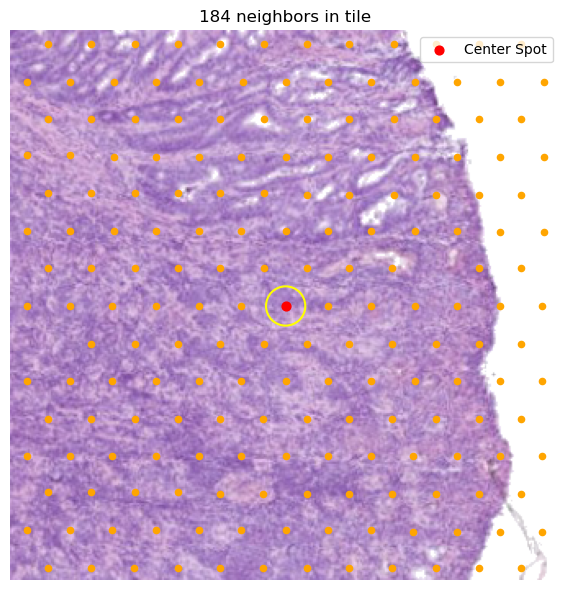

In [6]:
import random

tile_size = round(max(train_spacing_per_slide.values())*3)  # → round(77.7) → 78
print(f"\n🔍 所有 slide tile size {tile_size} pixels")

df = train_spot_tables['S_1']
i = random.randint(0, len(df) - 1)

row = df.iloc[i]

x = row['x']
y = row['y']

# 取得tile範圍內的spot們
neighbors_df = get_spots_in_tile(df, x, y, tile_size=336)

print(f"Found {len(neighbors_df)} spots in this tile.")
#print(neighbors_df[['x', 'y']])
##print(x,y)
plot_tile_with_spots(
    slide_image=image,
    spot_df=neighbors_df,
    center_x=x,
    center_y=y,
    tile_size=336,
    #grid_size=3,
    spot_radius_px=12
)


## Start tiling

### Just cut

In [16]:
from sklearn.preprocessing import MinMaxScaler
with h5py.File("dataset/spot-rank/version-1/directly_rank_train_spots_v2.h5", "r") as f:
    train_spots = f["spots/Train"]
    
    # Dictionary to store DataFrames for each slide
    train_spot_tables = {}
    
    for slide_name in train_spots.keys():
        # Load dataset as NumPy structured array
        spot_array = np.array(train_spots[slide_name])
        
        # Convert to DataFrame
        df = pd.DataFrame(spot_array)
        
        # Store in dictionary
        train_spot_tables[slide_name] = df
# ======= 資料儲存區 =======

train_L_tiles = []
train_labels = []

bad_spots = []

# ======= 主迴圈 =======
#with h5py.File("./dataset/filtered&masked_dataset.h5", "r") as h5file:

with h5py.File("dataset/masked_images_train.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    slide_ids = list(train_spot_tables.keys())

    for slide_id in slide_ids:
        if slide_id not in train_images:
            print(f"⚠️ Slide {slide_id} not found in HDF5, skipping.")
            continue

        image = train_images[slide_id][()]  # H x W x 3
        df = train_spot_tables[slide_id]

        # Step 4: 標準化座標
        ext_coords = df[['x', 'y']].values
        scaler = MinMaxScaler()
        coords_normalized = scaler.fit_transform(ext_coords)
        df[['x_normalized', 'y_normalized']] = coords_normalized

        for i, row in df.iterrows():
            x, y = int(row['x']), int(row['y'])
            nx, ny = row['x_normalized'], row['y_normalized']

            tile, padded = extract_tile_fixed(image, x, y, tile_size=78, pad_mode="edge")
            label = row.iloc[2:-2].values.astype(np.float32)

            train_L_tiles.append(tile)
            train_labels.append(label)

            if padded is not None:
                bad_spots.append((slide_id, padded[0], padded[1]))
                
print(f"⚠️ 共 {len(bad_spots)} 個 spot 發生 padding：")
for sid, x, y in bad_spots[:5]:
    print(f" - {sid}: ({x}, {y})")

⚠️ 共 0 個 spot 發生 padding：


Tile shape: (336, 336, 3)


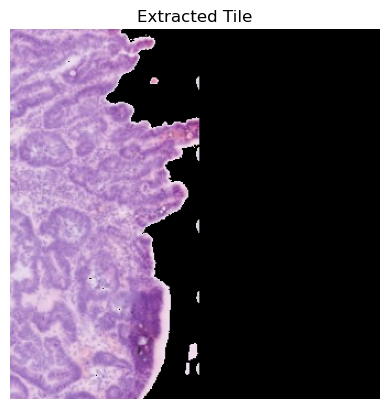

In [18]:
with h5py.File("dataset/masked_images_train.h5", "r") as f:
    img = f["images/Train"]["S_1"][:]  # 用 [:] 讀成 NumPy array
    tile, _ = extract_tile_fixed(img, 1817, 1068, tile_size=336, pad_mode="edge")
    print(f"Tile shape: {tile.shape}")
    plt.imshow(tile)
    plt.title("Extracted Tile")
    plt.axis("off")
    plt.show()


### Augmentation

In [19]:
def split_into_subtiles(tile, grid_size=3):
    """
    將 tile 切成 grid_size x grid_size 的 subtiles
    """
    H, W, C = tile.shape
    assert H % grid_size == 0 and W % grid_size == 0
    h_step, w_step = H // grid_size, W // grid_size

    subtiles = []
    for i in range(grid_size):
        for j in range(grid_size):
            y1, y2 = i * h_step, (i + 1) * h_step
            x1, x2 = j * w_step, (j + 1) * w_step
            sub_tile = tile[y1:y2, x1:x2, :]
            subtiles.append(sub_tile)
    return subtiles  # 會回傳 9 個 (H/3, W/3, C)



In [162]:
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm   # pip install tqdm

# ------------------------------------------------------------------
# 檢查資料
# ------------------------------------------------------------------
try:
    n_tiles = len(train_L_tiles)
except NameError:
    raise RuntimeError("變數 train_L_tiles 不存在，請先載入你的影像清單/陣列。")

# ------------------------------------------------------------------
# 輸出資料夾
# ------------------------------------------------------------------
out_dir = Path("./images/ls")
out_dir.mkdir(parents=True, exist_ok=True)

# ------------------------------------------------------------------
# 逐張寫檔
# ------------------------------------------------------------------
for idx, tile in tqdm(enumerate(train_L_tiles), total=n_tiles, desc="Saving PNG"):
    # 👉 若 tile 為 float32/float64、值域 0-1
    if np.issubdtype(tile.dtype, np.floating):
        tile_uint8 = np.clip(tile * 255, 0, 255).round().astype(np.uint8)
    else:
        tile_uint8 = tile.astype(np.uint8, copy=False)

    # 假設原本是 RGB；OpenCV 需 BGR
    tile_bgr = cv2.cvtColor(tile_uint8, cv2.COLOR_RGB2BGR)

    filename = out_dir / f"tile_{idx:06d}.png"
    cv2.imwrite(str(filename), tile_bgr)

print(f"✅ 全部 {n_tiles} 張已存到 {out_dir.resolve()}")

Saving PNG: 100%|██████████| 8069/8069 [00:05<00:00, 1519.05it/s]

✅ 全部 8069 張已存到 /Users/deweywang/Desktop/GitHub/HEVisum/images/ls


In [163]:
!python Real-ESRGAN/inference_realesrgan.py -n RealESRGAN_x4plus -i 'images/ls/' -o 'images/results' --outscale 1

/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spatialhackathon/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might b

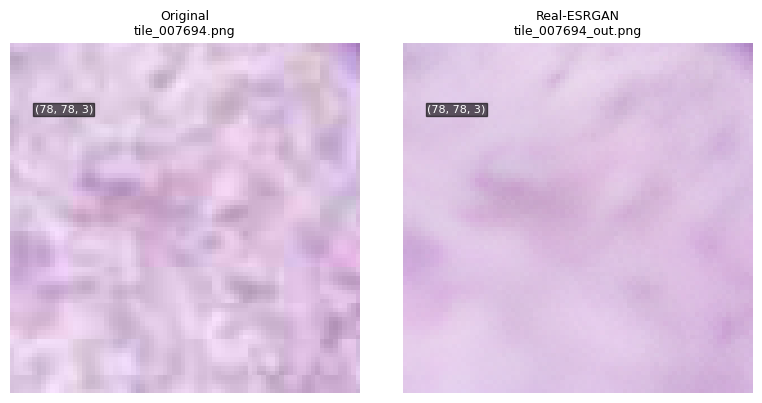

In [189]:
import random, glob
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 資料夾設定
# ------------------------------------------------------------
orig_dir = Path("images/ls")       # 存原始 tile 的資料夾
res_dir  = Path("images/results")  # 存 Real‑ESRGAN 結果的資料夾
exts     = ("*.png", "*.jpg", "*.jpeg")  # 支援的副檔名

# ------------------------------------------------------------
# ❶ 隨機挑 1 張原圖
# ------------------------------------------------------------
files = [f for ext in exts for f in orig_dir.glob(ext)]
if not files:
    raise FileNotFoundError(f"{orig_dir} 內找不到任何影像檔！")
orig_path = Path(random.choice(files))
stem = orig_path.stem           # 例如 "tile_012345"

# ------------------------------------------------------------
# ❷ 在結果資料夾找對應超解析檔
#    允許 tile_012345_out.png 或 tile_012345_out@2x.png …
# ------------------------------------------------------------
candidates = list(res_dir.glob(f"{stem}_out*.*"))
if not candidates:
    raise FileNotFoundError(
        f"在 {res_dir} 找不到 {stem} 的超解析結果，"
        "請先確認 Real‑ESRGAN 已經輸出檔案。"
    )
upsampled_path = candidates[0]   # 若有多檔就取第一個

# ------------------------------------------------------------
# ❸ 讀檔（BGR）→ RGB
# ------------------------------------------------------------
orig_bgr = cv2.imread(str(orig_path))
ups_bgr  = cv2.imread(str(upsampled_path))
if orig_bgr is None or ups_bgr is None:
    raise RuntimeError("讀檔失敗，可能影像已損毀或路徑錯誤。")

orig_rgb = cv2.cvtColor(orig_bgr, cv2.COLOR_BGR2RGB)
ups_rgb  = cv2.cvtColor(ups_bgr,  cv2.COLOR_BGR2RGB)

# 尺寸
h0, w0, _ = orig_rgb.shape
h1, w1, _ = ups_rgb.shape

# ------------------------------------------------------------
# ❹ 畫圖：並排 + 解析度標籤
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(orig_rgb)
axes[0].set_title(f"Original\n{orig_path.name}", fontsize=9)
axes[0].text(
    5, 15, f"{orig_rgb.shape}", color="white", fontsize=8,
    bbox=dict(facecolor="black", alpha=0.6, pad=1)
)
axes[0].axis("off")

axes[1].imshow(ups_rgb)
axes[1].set_title(f"Real‑ESRGAN\n{upsampled_path.name}", fontsize=9)
axes[1].text(
    5, 15, f"{ups_rgb.shape}", color="white", fontsize=8,
    bbox=dict(facecolor="black", alpha=0.6, pad=1)
)
axes[1].axis("off")

plt.tight_layout()
plt.show()


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_14932/4043827029.py:13: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=1, alpha_affine=5, p=0.7),


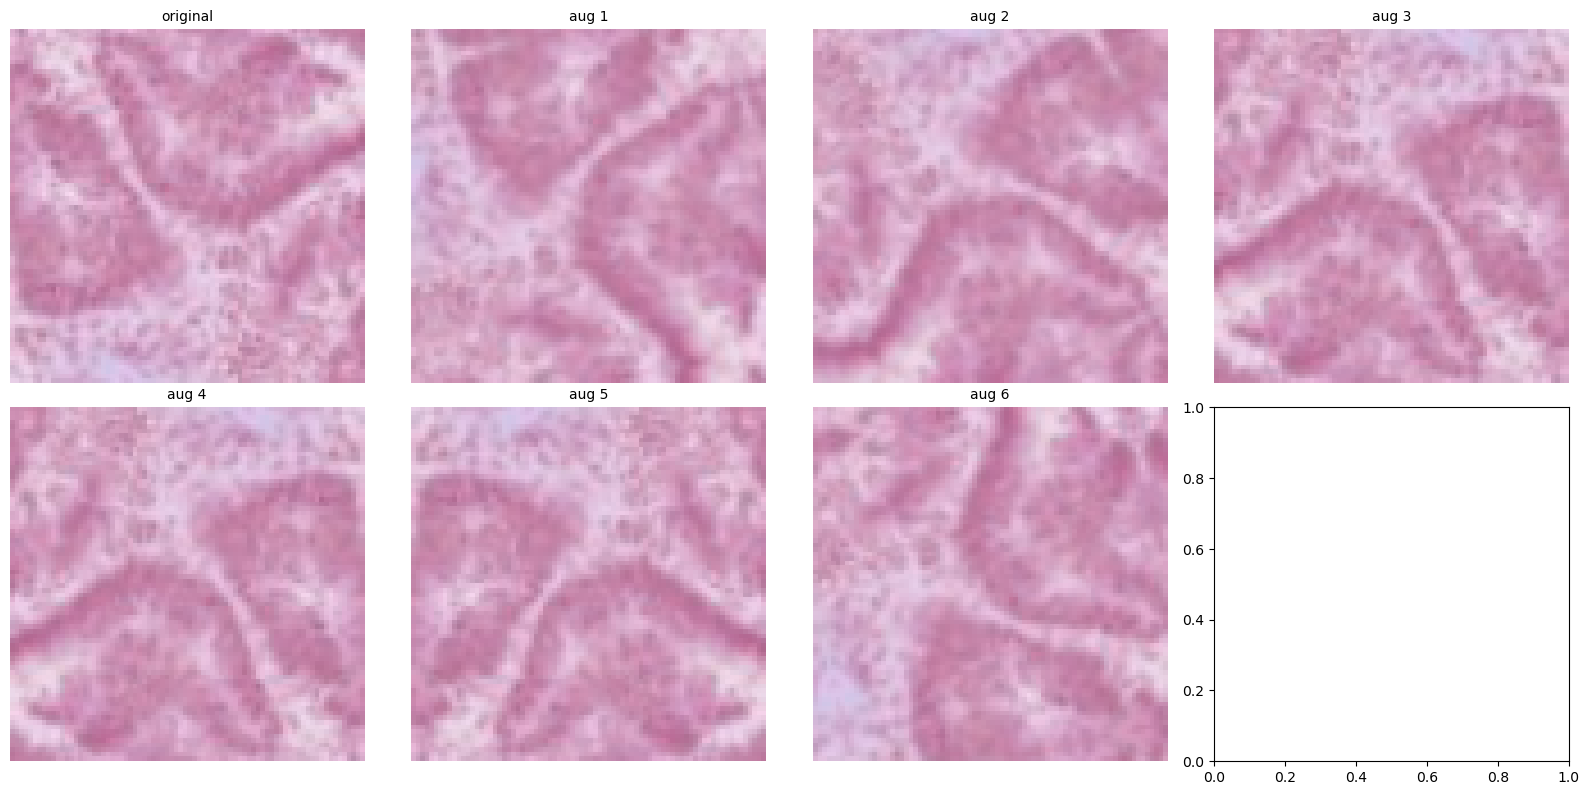

In [196]:
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import cv2

# ------------------------------------------------------------------
# Define the SAME augmentation pipeline you used when saving tiles
# ------------------------------------------------------------------
augment_transform = A.ReplayCompose([
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
    A.Rotate(limit=90, p=0.6),
    A.ElasticTransform(alpha=1, sigma=1, alpha_affine=5, p=0.7),
])

# ------------------------------------------------------------------
# Grab the very first tile from train_L_tiles
# ------------------------------------------------------------------
try:
    original = train_L_tiles[0]  # H x W x C (assumed RGB/BGR)
except NameError as e:
    raise RuntimeError(
        "Variable `train_L_tiles` not found. "
        "Make sure your tile list/array is already loaded into memory."
    ) from e

# ------------------------------------------------------------------
# Generate 6 augmented versions
# ------------------------------------------------------------------
augmented_imgs = []
for _ in range(6):
    aug = augment_transform(image=original)["image"]
    augmented_imgs.append(aug)

# ------------------------------------------------------------------
# Plot: original + 6 augmentations (2 rows × 4 columns)
# ------------------------------------------------------------------
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
all_imgs = [original] + augmented_imgs
titles = ["original"] + [f"aug {i+1}" for i in range(6)]

for ax, img, t in zip(axes.flat, all_imgs, titles):
    # If the image is BGR (OpenCV default), convert to RGB for display
    if img.shape[-1] == 3:
        img_disp = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img_disp = img.squeeze()
    ax.imshow(img_disp)
    ax.set_title(t, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [20]:
import torch
import os
import albumentations as A

save_dir = "dataset/spot-rank/version-1/only_tile_sub/train"
os.makedirs(save_dir, exist_ok=True)

counter = 0
augment_transform = A.ReplayCompose([
    A.HorizontalFlip(p=0.8),
    A.VerticalFlip(p=0.8),
    A.Rotate(limit=90, p=0.6),
    A.ElasticTransform(alpha=1, sigma=1, alpha_affine=5, p=0.7),
])

N = 10
    
for i, (l_tile, label ) in enumerate(zip(train_L_tiles, train_labels)):
    for _ in range(N):
        transformed = augment_transform(image=l_tile)
        center_tile = transformed['image']

        subtiles = split_into_subtiles(center_tile)  # 9 tiles
        if len(subtiles) !=9 :
            print(f"{i} have wrong size {len(subtiles)}")
        data = {
            "tile": center_tile,
            "subtiles": np.stack(subtiles),
            "label": label,
            "source_idx": i  # 🔁 可以追蹤來自第幾筆原始資料
        }

        torch.save(data, os.path.join(save_dir, f"tile_{counter:06d}.pt"))
        counter += 1
# ------------------------------------------
# 💾 儲存原始資料（未經 augment）
# ------------------------------------------
start_counter = len([f for f in os.listdir(save_dir) if f.endswith(".pt") and not f.startswith("original")])
print(f"📦 原始資料從 index {start_counter} 開始儲存...")

for i, (l_tile, label) in enumerate(zip(train_L_tiles, train_labels )):
    try:
        center_tile = l_tile  # 9 tiles
        subtiles = split_into_subtiles(center_tile)
        if len(subtiles) !=9 :
            print(f"{i} have wrong size {len(subtiles)}")
        data = {
            "tile": center_tile,
            "subtiles": np.stack(subtiles),
            "label": label,
            "source_idx": i  # 🔁 可以追蹤來自第幾筆原始資料
        }

        file_path = os.path.join(save_dir, f"tile_{start_counter + i:06d}.pt")
        torch.save(data, file_path)

    except Exception as e:
        print(f"❌ 第 {i} 筆資料儲存失敗：{e}")
print(f"✅ 原始資料已儲存至 {save_dir}original_data.pt")


/opt/anaconda3/envs/spatialhackathon/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_61988/484886831.py:13: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  A.ElasticTransform(alpha=1, sigma=1, alpha_affine=5, p=0.7),


📦 原始資料從 index 80690 開始儲存...
✅ 原始資料已儲存至 dataset/spot-rank/version-1/only_tile_sub/trainoriginal_data.pt


In [96]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

def to_uint8(img):
    """將 float 或 uint8 圖片轉為 RGB uint8 格式"""
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 1) if img.max() <= 1.0 else np.clip(img / 255.0, 0, 1)
        img = (img * 255).astype(np.uint8)
    if img.shape[-1] == 4:
        img = img[..., :3]
    return img


def draw_border(img, color=(0, 255, 0), thickness=2):
    """在 tile 圖片上加綠色邊框"""
    h, w = img.shape[:2]
    return cv2.rectangle(img.copy(), (0, 0), (w - 1, h - 1), color, thickness)


def visualize_tiles_and_subtiles(tile, neighbors, subtiles, title_prefix="Tile", subtile_grid_size=2):
    """
    顯示：
    - 中心 tile + 8 neighbors（3x3）
    - center tile 拆解後的 subtiles，支援 2x2 或 3x3
    """
    tile = to_uint8(tile)
    tile = draw_border(tile)

    neighbors = [draw_border(to_uint8(n)) for n in neighbors]
    subtiles = [draw_border(to_uint8(s)) for s in subtiles]

    H, W, _ = tile.shape
    sH, sW, _ = subtiles[0].shape

    # 1️⃣ 拼接 3×3 網格（中心 + neighbors）
    grid3x3 = np.zeros((3 * H, 3 * W, 3), dtype=np.uint8)
    neighbor_idx = 0

    for i in range(3):
        for j in range(3):
            y1, y2 = i * H, (i + 1) * H
            x1, x2 = j * W, (j + 1) * W
            if i == 1 and j == 1:
                patch = tile
                text = "C"  # center
            else:
                patch = neighbors[neighbor_idx]
                text = str(neighbor_idx + 1)
                neighbor_idx += 1
            patch = cv2.putText(patch, text, (10, 25),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
            grid3x3[y1:y2, x1:x2, :] = patch

    # 2️⃣ 拼接 subtiles（支援 2×2 或 3×3）
    grid_size = subtile_grid_size
    total_subs = len(subtiles)
    grid_sub = np.zeros((grid_size * sH, grid_size * sW, 3), dtype=np.uint8)

    for idx, subtile in enumerate(subtiles):
        i = idx // grid_size
        j = idx % grid_size
        y1, y2 = i * sH, (i + 1) * sH
        x1, x2 = j * sW, (j + 1) * sW
        patch = subtile.copy()
        patch = cv2.putText(patch, str(idx + 1), (10, 25),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 0, 0), 2)
        grid_sub[y1:y2, x1:x2, :] = patch

    # 3️⃣ 顯示圖
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(grid3x3)
    plt.title(f"{title_prefix} - 3×3 Neighbors + Center")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(grid_sub)
    plt.title(f"{title_prefix} - {grid_size}×{grid_size} Subtiles of Center")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

import os
import torch
import random
def visualize_random_augmented_tile(data_dir="./dataset/112-3sizes/", subtile_grid_size = 2):
    """
    從指定資料夾隨機選一筆 tile 檔案並畫出中心 + neighbor + subtile。
    """
    # 找出所有 tile 檔案（排除 original_data.pt）
    pt_files = [f for f in os.listdir(data_dir) if f.endswith(".pt") and not f.startswith("original")]
    if not pt_files:
        print("❌ 資料夾中找不到 .pt 檔案")
        return

    # 隨機選一筆
    random_file = random.choice(pt_files)
    file_path = os.path.join(data_dir, random_file)

    # 讀取資料
    data = torch.load(file_path)

    print(f"🧪 檢查檔案：{random_file}")

    visualize_tiles_and_subtiles(
        tile=data["tile"],
        neighbors=data["neighbors"],
        subtiles=data["subtiles"],
        title_prefix=random_file,
        subtile_grid_size=subtile_grid_size
    )


/var/folders/7g/j5s0yzcj34l3v043s7znkplc0000gn/T/ipykernel_18949/4213543312.py:103: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


🧪 檢查檔案：tile_027779.pt


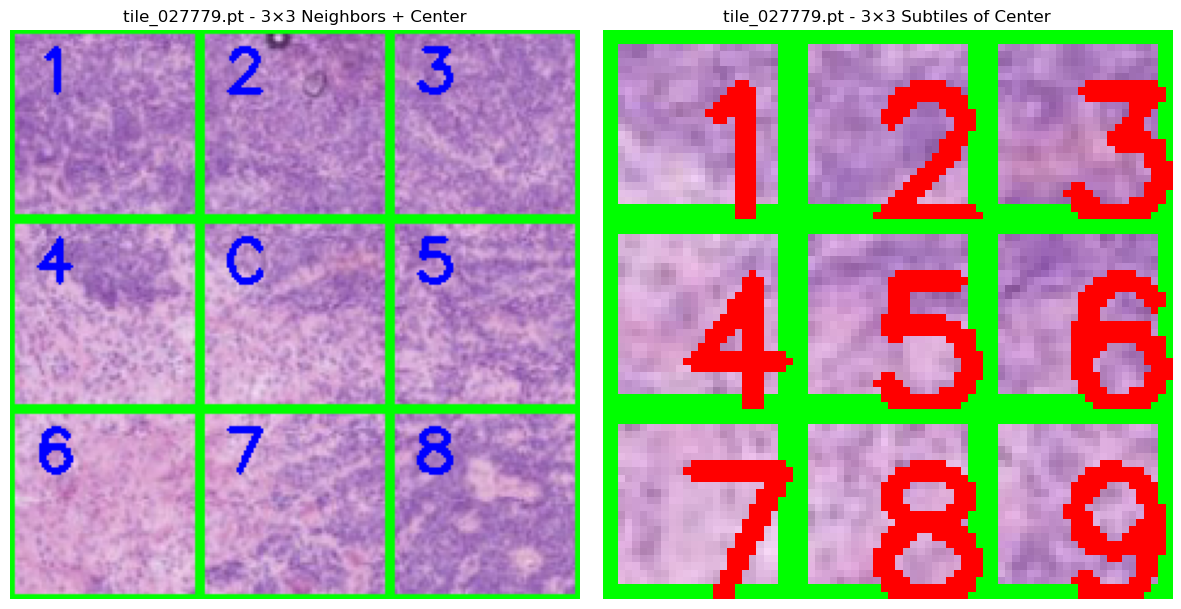

In [111]:
visualize_random_augmented_tile(save_dir, 3)


# Test data preparation

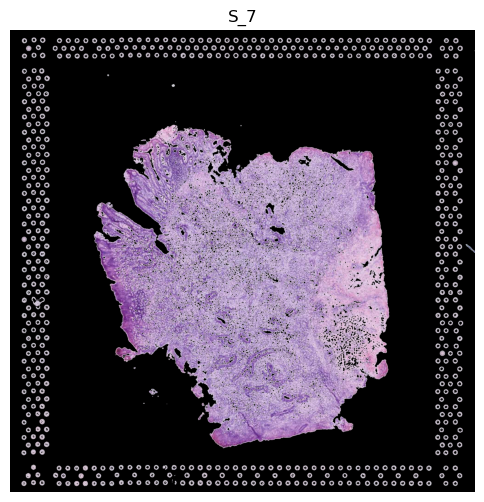

In [21]:
# Visualize Test slide ('S_7')
with h5py.File("dataset/masked_images_test.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    
    sample = 'S_7'
    image = np.array(test_images[sample])

    plt.figure(figsize=(6,6))
    plt.imshow(image, aspect="auto")
    plt.axis('off')
    plt.title(sample)
    plt.show()

In [22]:
# Display spot table for Test slide (only the spot coordinates on 2D array)
with h5py.File("./dataset/elucidata_ai_challenge_data.h5", "r") as f:
    test_spots = f["spots/Test"]
    print(test_spots.keys())
    spot_array = np.array(test_spots['S_7'])
    test_spot_table = pd.DataFrame(spot_array)
    
# Show the test spots coordinates for slide 'S_7'
test_spot_table

<KeysViewHDF5 ['S_7']>


,x,y,Test_Set
0,1499,1260,2
1,1435,1503,2
2,558,1082,2
3,736,1304,1
4,1257,1592,1
...,...,...,...
2083,736,639,2
2084,1016,684,2
2085,1181,839,2
2086,735,1436,1


In [31]:
coords = test_spot_table[['x', 'y']].values
# 計算距離矩陣（所有 spot 之間）
dist_matrix = squareform(pdist(coords))  # shape = (N, N)

# 把對角線設為無限大（自己對自己不算）
np.fill_diagonal(dist_matrix, np.inf)

# 取得每個 spot 最近的一個鄰居距離
min_dists = dist_matrix.min(axis=1)

# 算平均距離
mean_spacing = min_dists.mean()

print(f"平均每個 spot 間距：約 {mean_spacing:.2f} pixels")

平均每個 spot 間距：約 25.01 pixels


In [25]:
import h5py
import numpy as np

test_tiles = []
test_subtiles = []
bad_spots =[]

with h5py.File("dataset/masked_images_test.h5", "r") as h5file:
    test_images = h5file["images/Test"]
    
    slide_ids = list(test_images.keys())  # e.g., only ['S_7']
    # Step 4: 標準化座標
    df = test_spot_table

    ext_coords = df[['x', 'y']].values
    scaler = MinMaxScaler()
    coords_normalized = scaler.fit_transform(ext_coords)
    df[['x_normalized', 'y_normalized']] = coords_normalized
    
    for i, row in df.iterrows():
        x, y = int(row['x']), int(row['y'])

        tile, padded = extract_tile_fixed(image, x, y, tile_size=78, pad_mode="edge")

        subtiles = split_into_subtiles(tile, 3)  # 9 tiles

        

        test_tiles.append(tile)
        test_subtiles.append(subtiles)  # ✅ 存入
        if padded is not None:
            bad_spots.append((slide_id, padded[0], padded[1]))
                
print(f"⚠️ 共 {len(bad_spots)} 個 spot 發生 padding：")
for sid, x, y in bad_spots[:5]:
    print(f" - {sid}: ({x}, {y})")

⚠️ 共 0 個 spot 發生 padding：


In [26]:
## Make sure I have all the data     

print(f"Total number of spots across all slides: {len(test_spot_table)}")
print(f"The spots in our preprocessing datasets: {len(test_tiles)}")

Total number of spots across all slides: 2088
The spots in our preprocessing datasets: 2088


In [27]:
import torch
import os
output_dir = "dataset/spot-rank/version-1/only_tile_sub/masked_test"

os.makedirs(output_dir, exist_ok=True)
best_model_path = os.path.join(output_dir, "test_dataset.pt")

torch.save({
    'tiles': test_tiles,
    'subtiles': test_subtiles,
}, best_model_path)



print("✅ 所有資料已成功儲存到 final_data 資料夾！")


✅ 所有資料已成功儲存到 final_data 資料夾！
